# NCAA Embeddings with Advanced Statistics
> Enriching advanced statistics with opponent context.

- toc: true 
- badges: true
- comments: true
- image: images/embeddings_preview.png
- categories: [kaggle]

![](https://raw.githubusercontent.com/rysarmstr/Data-Bites-Blog/master/images/embeddings_preview.png "Left: T-SNE team embeddings trained from win/loss and point differential data. Right: Raw data aggregated by team.")


## Summary of findings
One issue with using aggregated regular season statistics in an NCAA tournament model is that it doesn't account for opponent strength of schedule. We can use embeddings to extend pair-wise comparison methods, like the Bradley-Terry model, to more complex metrics than just wins and losses. These methods assume static team skill, but qualitatively appear more robust than aggregating statistics.

Update: See [this post](https://rysarmstr.github.io/Data-Bites-Blog/kaggle/2020/05/10/Simple-NCAA-Tournament-Model.html) for a simple comparison of tournament models built with the emebeddings and aggregated point data. The embeddings provide an uplift over the data they were trained by. More testing is needed to see if embeddings prove useful when extended to advanced statistics.

**Note: This work was inspired by [this Kaggle notebook](https://www.kaggle.com/abhijitbrahme/embedding-ncaa-model), which is the Kaggle notebook I've seen applying embeddings to the NCAA tournament. Here is a second example of embeddings used for [baseball](https://www.youtube.com/watch?v=nQK44L9j9hY&list=UUk36k_W8ew3v2ZDjQgKi10Q&index=83) (this is a great place to start if you are not familiar with embeddings) and the concept could easily be applied to other sports.**


## Introduction

I expected to compete in my first Kaggle competitions this March - both the NCAA [Men's](https://www.kaggle.com/c/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament) and [Women's](https://www.kaggle.com/c/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament) basketball tournaments. Unfortunately, both tournaments were canceled because of the covid-19 pandemic. Regardless, working through my different ideas was a great way to learn some of the basics and nuances of training an ML model effectively.

The typical successful model on Kaggle is an XGBoost ensemble model aimed at classifying wins and losses of tournament games. The biggest differences generally come down to feature selection and engineering. A key advantage of neural networks is the ability of a large network to learn non-linear relationships, which ultimately reduces the necessity for complex feature engineering. However, training and test data are limited in this case. The most detailed data set extend back to 2003, ~1,140 games. Many of these games have spurious results that the best models would not predict. As expected, a neural network architecture without feature engineering performs much more poorly on this data set; a network with feature engineering performs similarly to an XGBoost model. In future posts, I will explore more complex deep learning architectures such as RNNs for tournament prediction, but here I'll focus on feature engineering.

The easiest way to generate features for tournament prediction is to average a team's regular season statistics. The Kaggle data set contains various statistics, but users also commonly generate [advanced statistics](https://bleacherreport.com/articles/1813902-advanced-nba-stats-for-dummies-how-to-understand-the-new-hoops-math) before aggregation. The aggregated features are useful, but do not compensate for opponent strength. If a team had an easy schedule, it may have artificially higher statistics than another. Some methods like the [Bradley-Terry model](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model) (implemented in Python [here](https://pypi.org/project/choix/)), solve for single-value team strengths using previous comparisons of results across all teams. This implementation solves for team strengths based only on wins and losses and couldn't possibly distinguish between aspects of a team's strength (e.g. differentiating defensive skill from offensive skill).

But what if we generalize this concept of pairwise-comparisons using [embeddings](https://en.wikipedia.org/wiki/Word_embedding)? Embeddings are can be any length and can be trained to represent complex relationships. This notebook will generate team-level embeddings, representative of regular season data (win/losses, point differential, court location) that could be used to train a tournament model. A simple exploratory analysis suggests that the trained embeddings are a richer representation of the original feature data set, that could be implemented in a tournament model. Future testing and expansion of this method to advanced statistics will be needed to confirm that!

**What you will see in this notebook:**
 - Brief data prep - we are only using wins/losses, points, home/away, and team IDs as inputs to the model. *Later, I will expand this model to advanced statistics*, but training the model on this subset of data allows us to test the concept all the way back to 1985!
 - Model build - This model is being built with the sole purpose of generating useful embeddings. To achieve that we are training the model to be predictive of features that we would ordinarily use as feature inputs to a real tournament model (in this case, regular season wins and losses).
 - Training and validation - the model is trained using only regular season data from all years and is validated on a secondary set of tournament data ([NIT](https://en.wikipedia.org/wiki/National_Invitation_Tournament)). This is difficult because we have a slight mismatch between our training and validation data. The validation data is generally similar and likely more representative of the real NCAA tournament. That is okay; the end goal of this model is trained embeddings and not win prediction.
 - Sense check and exploratory analysis - First thing is to check that predictions from the model are sensible, but what we really care about is the embeddings. Do they carry more useful information than simple aggregations of the data they represent? In short, Yes!

In [1]:
#collapse_hide
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
import keras as k
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Multiply, Lambda, Concatenate, Add, Subtract
from keras.layers.embeddings import Embedding
from keras.initializers import glorot_uniform, glorot_normal, Constant
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.manifold import TSNE
import altair as alt
np.random.seed(13)

/Users/ryanarmstrong/opt/miniconda3/envs/ds37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ryanarmstrong/opt/miniconda3/envs/ds37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ryanarmstrong/opt/miniconda3/envs/ds37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/ryanar

## Input data

Kaggle provides two regular season data sets: one with less detailed statistics dating back to 1985, and one with more detailed statistics dating back to 2003. For this proof of concept, I'll simplify the model by working with the older data set. The model will be trained on less powerful statistics, but we will have more historical context during data exploration. Let's preview the first few rows of the regular season data:

In [2]:
#collapse_hide
dataLoc=Path('../_notebooks/data/2020-05-04-NCAA-Embeddings/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage2/')

df_teams = pd.read_csv(dataLoc/'MTeams.csv')
teams_dict = df_teams[['TeamID','TeamName']].set_index('TeamID').to_dict()['TeamName']

df_regSeason_data = pd.read_csv(dataLoc/'MRegularSeasonDetailedResults.csv')
df_regSeason_data.head() # cols = Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


Each game is listed only once, with separate columns for winner and loser statistics. The data will be reformatted to leave us with the following inputs and outputs to the model:
 - Team IDs
 - Team locations (home or away)
 - Odds of 'Team A' winning (classification/logistic regression)
 - Expected point differential (team A - team B, regression)

Each game is presented to the model twice, once as 'Team A vs. Team B', and then vice versa. Team IDs also need to be reformatted to differentiate a single school's team by year (e.g. Duke 2019 $\neq$ Duke 2020). This may be an oversimplification, but is clearly a better assumption than treating the entire history of a school the same.

Finally, we want to use as much of the training data as possible to train the embeddings. Because the true accuracy of the model is insignificant, secondary tournament data (NIT) is used as training validation. This provides a sense that the model is training correctly, but doesn't require sacrificing valuable regular season or NCAA tournament data in the process. This data set has the same format as the regular season data and is processed accordingly.

In [3]:
#collapse_hide
# load validation data
df_otherTourney_data = pd.read_csv(dataLoc/'MNCAATourneyDetailedResults.csv')

# Create team encoding that differentiates teams by year and school
def newTeamID(df):
    # df = df.sample(frac=1).reset_index(drop=True)
    df['Wnewid'] = df['Season'].astype(str) + df['WTeamID'].astype(str)
    df['Lnewid'] = df['Season'].astype(str) + df['LTeamID'].astype(str)
    return df

df_regSeason_data = newTeamID(df_regSeason_data)
df_otherTourney_data = newTeamID(df_otherTourney_data)

def idDicts(df):
    newid_W = list(df['Wnewid'].unique())
    newid_L = list(df['Lnewid'].unique())
    ids = list(set().union(newid_W,newid_L))
    ids.sort()
    oh_to_id = {}
    id_to_oh = {}
    for i in range(len(ids)):
        id_to_oh[ids[i]] = i 
        oh_to_id[i] = ids[i]

    return oh_to_id, id_to_oh

oh_to_id, id_to_oh = idDicts(df_regSeason_data)    

# define advanced stats
def possessions(row):
    teamstats = (row['WFGM'] + 0.4 * row['WFTA'] - 1.07 * (row['WOR'] / (row['WOR'] + row['LDR'])) * (row['WFGA'] - row['WFGM']) + row['WTO'])
    opponentstats = (row['LFGM'] + 0.4 * row['LFTA'] - 1.07 * (row['LOR'] / (row['LOR'] + row['WDR'])) * (row['LFGA'] - row['LFGM']) + row['LTO'])
    return 0.5*teamstats+opponentstats


# add training data in swapped format so network sees both wins and losses
def swapConcat_data(df):

    df['Wnewid'] = df['Wnewid'].apply(lambda x: id_to_oh[x])
    df['Lnewid'] = df['Lnewid'].apply(lambda x: id_to_oh[x])
    
    df['Possessions'] = df.apply(possessions,axis=1)
    
    loc_dict = {'A':-1,'N':0,'H':1}
    df['WLoc'] = df['WLoc'].apply(lambda x: loc_dict[x])

    swap_cols = [
    'Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO',
    'LStl', 'LBlk', 'LPF', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR',
    'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'Lnewid', 'Wnewid', 'Possessions']
    
    df_swap = df[swap_cols].copy()

    df_swap['WLoc'] = df_swap['WLoc']*-1

    df.columns = [x.replace('WLoc','T1_Court')
                   .replace('W','T1_')
                   .replace('L','T2_') for x in list(df.columns)]

    df_swap.columns = df.columns

    df = pd.concat([df,df_swap])

    df['Win'] = (df['T1_Score']>df['T2_Score']).astype(int)
    df['Close_Game']= abs(df['T1_Score']-df['T2_Score']) <3
    df['Score_diff'] = df['T1_Score'] - df['T2_Score']
    df['Score_diff'] = df['Score_diff'] - (df['Score_diff']/df['Score_diff'].abs())
    df['T2_Court'] = df['T1_Court']*-1
    df[['T1_Court','T2_Court']] = df[['T1_Court','T2_Court']] + 1
    df['T1_SPP'] = df['T1_Score']/df['Possessions']
    df['T2_SPP'] = df['T2_Score']/df['Possessions']
    df['T1_BlkPP'] = df['T1_Blk']/df['Possessions']
    df['T1_FTMPP'] = df['T1_FTM']/df['Possessions']
    df['PDPP'] = df['Score_diff']/df['Possessions']

    cols = df.columns.to_list()

    df = df[cols].sort_index()
    df.reset_index(drop=True,inplace=True)


    return df

df_regSeason_full = swapConcat_data(df_regSeason_data.copy().sort_values(by='DayNum'))
df_otherTourney_full = swapConcat_data(df_otherTourney_data.copy())

# Convert to numpy arrays in correct format
def prep_inputs(df,id_to_oh, col_outputs):
    Xteams = np.stack([df['T1_newid'].values,df['T2_newid'].values]).T
    Xloc = np.stack([df['T1_Court'].values,df['T2_Court'].values]).T
    
    Y = df[col_outputs].values
    
    return [Xteams, Xloc], Y

X_train, Y_train = prep_inputs(df_regSeason_full, id_to_oh, ['PDPP'])
X_valid, Y_valid = prep_inputs(df_otherTourney_full, id_to_oh, ['PDPP'])

# Normalize point outputs - Win/loss unchanged
def normalize_outputs(Y_outputs, stats_cache=None):
    if stats_cache == None:
        stats_cache = {}
        stats_cache['mean'] = np.mean(Y_outputs, axis=0)
        stats_cache['var'] = np.var(Y_outputs, axis=0)
    else: pass
    
    Y_normout = (Y_outputs-stats_cache['mean'])/stats_cache['var']

    return Y_normout, stats_cache

Y_norm_train, stats_cache_train = normalize_outputs(Y_train,None)
Y_norm_valid, _ = normalize_outputs(Y_valid,stats_cache_train)



## Building the model
This model is built with two input types - home/away flags and team IDs. Each input is repeated for each team and is fed through a location embedding layer and a team embedding layer. The location embedding is 1-dimensional and multiplied by each team's embedding vector element by element. The team embeddings are separately fed through the same two-layers before being subtracted. This subtracted layer finally connects to two output layers - one 'softmax' for win/loss prediction and one dense layer with no activation for point prediction.

A lot of the choices I made here are subjective and would need to be tested against some other options. Among the obvious parameters like number of layers or units per layer are a key parameters that have a significant effect and haven't been fully explored. For example, should the location embedding activations be multiplied, added, or simply concatenated with the teams embedding layer? What should the dimensions of the teams embedding layer be? Some of these choices, like length of embeddings can be mitigated with regularization (dropout, weight decay), but something like how the two embedding layers combine could have a large effect. Regardless, let's move forward with the model as is.

![](https://raw.githubusercontent.com/rysarmstr/Data-Bites-Blog/master/images/embeddings_architecture.png "Conceptual architecture of embeddings network for pair-wise comparison. Not all elements to scale. See the Keras model summary below for network details.")


In [4]:
#collapse_hide
# build model

tf.keras.backend.clear_session()

def NCAA_Embeddings_Joint(nteams,teamEmb_size,numOut):
    team_input = Input(shape=[2,],dtype='int32', name='team_input')
    X_team = Embedding(input_dim=nteams, output_dim=teamEmb_size, input_length=2, embeddings_initializer=glorot_uniform(), name='team_encoding')(team_input)

    loc_input = Input(shape=[2,],dtype='int32', name='loc_input')
    X_loc = Embedding(input_dim=3, output_dim=1, input_length=2, embeddings_initializer=Constant(.5), name='loc_encoding')(loc_input)
    X_loc = Lambda(lambda z: k.backend.repeat_elements(z, rep=teamEmb_size, axis=-1))(X_loc)
    
    X = Multiply()([X_team,X_loc])
    X = Dropout(rate=.5)(X)
    T1 = Lambda(lambda z: z[:,0,:])(X)
    T2 = Lambda(lambda z: z[:,1,:])(X)

    D1 = Dense(units = 40, use_bias=True, activation='tanh')
    DO1 = Dropout(rate=.5)

    D2 = Dense(units = 20, use_bias=True, activation='tanh')
    DO2 = Dropout(rate=.5)

    X1 = D1(T1)
    X1 = DO1(X1)

    X1 = D2(X1)
    X1 = DO2(X1)

    X2 = D1(T2)
    X2 = DO1(X2)

    X2 = D2(X2)
    X2 = DO2(X2)

    X_sub = Subtract()([X1,X2])
    
    outputT1= Dense(units =numOut, use_bias=False, activation=None, name='T1_output')(X_sub)

    model = Model(inputs=[team_input, loc_input],outputs=outputT1,name='ncaa_embeddings_joint')

    return model

mymodel = NCAA_Embeddings_Joint(len(id_to_oh),2,Y_norm_valid.shape[1])
mymodel.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "ncaa_embeddings_joint"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
loc_input (InputLayer)          (None, 2)            0                                            
__________________________________________________________________________________________________
team_input (InputLayer)         (None, 2)            0                                            
__________________________________________________________________________________________________
loc_encoding (Embedding)        (None, 2, 1)         3           loc_input[0][0]                  
__________________________________________________________________________________________________
team_encoding (Embedding)       (None, 2, 2)         12374       team_input[0][0]                 
______

## Training the model
The model is trained using regular season data and validated using secondary tournament data (not the 'Big Dance'). The weights of the two losses are adjusted so that they back-propagate a similar amount of error. Because the point differential data has been normalized, the losses are multiple orders of magnitude less than the log loss metric for wins/losses. Given our goal is not really to predict wins and losses here, we could also train on only the point differential. We will see that the two end up being perfectly correlated anyway, but using both gives us a framework for how this could be implemented with advanced statistics in a future example.

In [5]:
#collapse_show
# Joint model
optimizer = Adam(learning_rate=.1, beta_1=0.9, beta_2=0.999, amsgrad=False)
mymodel.compile(loss='mse',
#                 loss_weights=[0.5,400],
                optimizer=optimizer,
                metrics = ['mse'])
numBatch = round(X_train[0].shape[0]/5)
results = mymodel.fit(X_train, Y_norm_train, validation_data=(X_valid, Y_norm_valid), epochs = 40, batch_size = numBatch,shuffle=True, verbose=False)


Instructions for updating:
Use tf.cast instead.


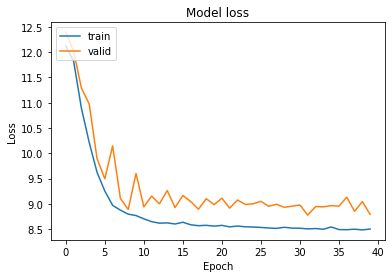

In [6]:
#collapse_hide
# accuracy = results.history['win_output_accuracy']
# val_accuracy = results.history['val_win_output_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
# # summarize history for accuracy
# plt.plot(accuracy)
# plt.plot(val_accuracy)
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## Model predictions
The cross plots for point differential and win/loss are generally well-behaved. The loss and accuracy of the model differ significantly from results on the Kaggle leaderboard for this competition. For reference, anything below a loss of 0.5 would be considered fantastic, and flipping a coin would give you a loss of about 0.69. We see a similar effect in the point spread prediction with a rather loose correlation of 0.47.

However, this model is optimized to train embeddings, not to predict tournament games. In fact, a model trained to predict winners and losers of regular season games would perform poorly on tournament data anyway. Only the best teams play in the tournament - different features matter and making predictions is even harder). So the model predictions aren't very useful, but the question still remains: are the embeddings meaningful? A comparison of the embeddings to the aggregated data used in training show that embeddings are a richer representation of the regular season data.

In [7]:
#collapse_hide
def transform_y(preds,stats_cache):
    preds = stats_cache['var'] * preds + stats_cache['mean']
    return preds

preds = mymodel.predict(X_valid)

x = transform_y(preds,stats_cache_train)
y = Y_valid
y[:,0].shape

(2230,)

Pearson coefficient:  0.57


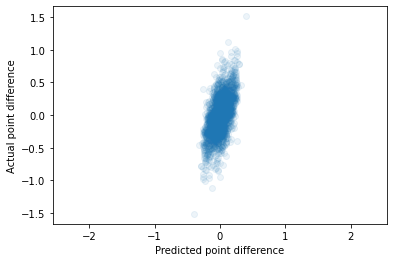

In [8]:
print('Pearson coefficient: ', round(stats.pearsonr(x[:,0], y[:,0])[0]*100)/100)
plt.scatter(x[:,0], y[:,0], alpha=0.08)
plt.xlabel('Predicted point difference')
plt.ylabel('Actual point difference')
plt.axis('equal')
plt.show()

In [9]:
# print('Pearson coefficient: ', round(stats.pearsonr(x[:,1], y[:,1])[0]*100)/100)
# plt.scatter(x[:,1], y[:,1], alpha=0.08)
# plt.xlabel('Predicted point difference')
# plt.ylabel('Actual point difference')
# plt.axis('equal')
# plt.show()

**As a brief aside:** One benefit of designing the network to predict pairwise-comparisons is its symmetry of predictions when the team order is swapped. Other ML models, such as XGBoost, treat the feature inputs of Team A and Team B differently, which can result in varying predictions when the teams are input in reverse order. This can be an issue even when training sets contain matchups and swapped matchups [as documented in this discussion](https://www.kaggle.com/c/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/discussion/130855).

## Exploratory analysis
The we trained two embeddings in this model - a location embeddings with length 1 for each entry and a teams embedding with length 8. The teams embedding is what we want to look at, but we will need to use [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to map the embeddings into length 2 vectors that we can more easily visualize. First let's take a peek at the location embedding:

In [10]:
#collapse_hide

df_locEmb = pd.DataFrame(mymodel.layers[2].get_weights()[0])
df_locEmb.index = ['Away','Neutral','Home']
df_locEmb.head()

,0
Away,0.100424
Neutral,0.118077
Home,0.389691


Remember that this these elements are multiplied by each team for each game. For a game at a neutral site, each team would get an equivalent boost and it would be a wash. However, The model gives a significant multiplier to the home team. It seems that it wouldn't make much sense to apply a multiplier to a team embedding that can be positive or negative. After all, do we really expect a poor team to be even worse on their home court? It seems more logical that the team and location embeddings should be added, but a quick test showed very similar final results. Another option is to just concatenate the two embeddings and let the network decide. 

Now, let's look at the team embeddings.

In [11]:
embeddings = mymodel.layers[3].get_weights()[0]
pd.DataFrame(embeddings).head()

,0,1
0,-0.304078,-0.515414
1,-0.177441,-0.135398
2,-0.639086,-0.912140
3,1.779832,0.935925
4,-0.200875,-0.320315


Each row in the table above is a team. These values have been trained as a result of each team's regular season match-ups and could now be frozen and used as features in a tournament model. The numbers above are meaningless to us without context, and to visualize them we need to condense them down to a form that we can plot more easily. [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) is a non-linear mapping algorithm that can represent the vectors in 2D space. It tends to keep vectors that are similar in the embedding space clustered together in 2D space. In our case, t-SNE projects the embeddings into a warped space with the strongest teams tending toward one side and the weakest toward the other.

Let's take a look at some comparisons between our t-SNE embeddings with and the aggregated game statistics of each team. All of these plots (excluding the final plot for 2020) include only the NCAA tournament teams of a given year. The plots below also highlight a few different historical factors.
 - Tournament seed number
 - Number of NCAA Tournament games won that season
 - Tournament winners
 - Some of the biggest upsets (from these two articles -> [1](https://www.cbssports.com/college-basketball/news/march-madness-2019-the-10-biggest-upsets-ever-in-the-opening-weekend-of-the-tournament/), [2](https://fansided.com/2020/03/16/biggest-march-madness-upsets-ncaa-tournament/10/))
 - The tournament field by season
 - All data for all teams in the 2020 regular season

 

In [12]:
# collapse_hide
# t = TSNE(n_components=2,random_state=13)
# embed_tsne = t.fit_transform(embeddings)
embed_tsne=embeddings


df_regSeason_full['T1_TeamName'] = df_regSeason_full['T1_TeamID'].apply(lambda x: teams_dict[x]) + '-' + df_regSeason_full['Season'].astype(str)
df_agg=df_regSeason_full.groupby('T1_TeamName').mean()
df_agg.reset_index(inplace=True,drop=False)

df_agg[['T1_TeamName','T1_SPP','T2_SPP']]
df_agg.drop(columns='Season',inplace=True)

df_tourney_data = pd.read_csv(dataLoc/'MNCAATourneyCompactResults.csv')
df_tourney_data['WTeamName'] = df_tourney_data['WTeamID'].apply(lambda x: teams_dict[x]) + '-' + df_tourney_data['Season'].astype(str)
df_tourney_data['Wins'] = 0
df_wins = df_tourney_data[['WTeamName','Wins']].groupby('WTeamName').count()
tourneyWinners = [df_tourney_data.loc[df_tourney_data['Season']==s,'WTeamName'].values[-1] for s in df_tourney_data['Season'].unique()]

df_seeds = pd.read_csv(dataLoc/'MNCAATourneySeeds.csv')
df_seeds['TeamName'] = df_seeds['TeamID'].apply(lambda x: teams_dict[x]) + '-' + df_seeds['Season'].astype(str)
df_seeds['Seed'] = df_seeds['Seed'].str.extract(r'(\d+)')
df_seeds['WonTourney'] = df_seeds['TeamName'].apply(lambda x: True if x in tourneyWinners else False)
df_seeds = df_seeds[['TeamName','Seed','WonTourney']]

df_upsets = pd.read_csv('../_notebooks/data/2020-05-04-NCAA-Embeddings/Upsets.csv')
df_upsets['David']=df_upsets['David']+'-'+df_upsets['Season'].astype(str)
df_upsets['Goliath']=df_upsets['Goliath']+'-'+df_upsets['Season'].astype(str)
upsets = {}
for ii in df_upsets['David'].unique():
    upsets[ii] = 'Surprise'
for ii in df_upsets['Goliath'].unique():
    upsets[ii] = 'Bust'
df_seeds = pd.merge(left=df_seeds, right=df_wins, how='left', left_on='TeamName',right_index=True)
df_seeds['Wins'].fillna(0,inplace=True)

def upset(x):
    try:
        y = upsets[x]
    except:
        y = None
    return y
df_seeds['Upset'] = df_seeds['TeamName'].apply(lambda x: upset(x))

df = pd.DataFrame(embed_tsne,columns=['factor1','factor2'])
df['TeamName'] = [str(teams_dict[int(oh_to_id[x][-4:])]) + '-' + oh_to_id[x][:4] for x in df.index]
df['Season'] = [int(oh_to_id[x][:4])for x in df.index]

df = pd.merge(left=df, right=df_seeds, how='left', on='TeamName')
df = pd.merge(left=df, right=df_agg, how='left', left_on='TeamName',right_on='T1_TeamName')

df = df[['TeamName','Season','factor1','factor2','T1_SPP','T2_SPP','Seed','Wins','Upset','WonTourney']]
df.columns = ['TeamName','Season','factor1','factor2','O_eff','D_eff','Seed','TourneyWins','Upset','WonTourney']

df2020 = df[df['Season']==2020].copy()

df.dropna(inplace=True,subset=['Seed'])

df['TourneyWinsScaled'] = df['TourneyWins']/df['TourneyWins'].max()
df['SeedScaled'] = df['Seed'].astype(int)/df['Seed'].astype(int).max()

In [13]:
df

,TeamName,Season,factor1,factor2,O_eff,D_eff,Seed,TourneyWins,Upset,WonTourney,TourneyWinsScaled,SeedScaled
2,Alabama-2003,2003,-0.639086,-0.912140,1.447391,1.371196,10,0.0,None,False,0.000000,0.6250
9,Arizona-2003,2003,-3.303756,-3.107499,1.523969,1.269768,01,3.0,None,False,0.500000,0.0625
10,Arizona St-2003,2003,-1.290913,-1.256173,1.364420,1.241350,10,1.0,None,False,0.166667,0.6250
16,Auburn-2003,2003,-1.014979,-0.887867,1.357963,1.267580,10,2.0,None,False,0.333333,0.6250
17,Austin Peay-2003,2003,-0.442811,-0.308671,1.328139,1.294047,13,0.0,None,False,0.000000,0.8125
...,...,...,...,...,...,...,...,...,...,...,...,...
5808,Virginia Tech-2019,2019,-2.916052,-3.360148,1.550904,1.283818,04,2.0,None,False,0.333333,0.2500
5816,Washington-2019,2019,-0.943408,-0.590934,1.352485,1.242584,09,1.0,None,False,0.166667,0.5625
5825,Wisconsin-2019,2019,-2.386862,-2.311831,1.490252,1.329260,05,0.0,None,False,0.000000,0.3125
5826,Wofford-2019,2019,-2.588818,-2.501357,1.529075,1.275192,07,1.0,None,False,0.166667,0.4375


### How correlated are the embeddings to tournament seeding?
We see a high correlation between the assigned seed and our embeddings. Our embeddings appear to be a better representation of the seeding than the aggregated statistics, which makes sense since our method uses pair-wise comparisons and effectively accounts for team strength while aggregated statistics do not.

In [14]:
#collapse_hide

axis_ranges = [[-80,100],
               [-80,80],
               [1,1.8],
               [1,1.8]]

def plot_comparison(df, colorBy, orderBy, axis_ranges):

    selector = alt.selection_single(empty='all', fields=['TeamName'])

    base = alt.Chart(df).mark_point(filled=True,size=50).encode(
        color=alt.condition(selector,
                            colorBy,
                            alt.value('lightgray') ),
        order=orderBy,
        tooltip=['TeamName','Seed']
    ).properties(
        width=250,
        height=250
    ).add_selection(selector).interactive()

    chart1 = [alt.X('factor1:Q',
                    scale=alt.Scale(domain=axis_ranges[0]),
                    axis=alt.Axis(title='t-SNE factor 1')),
            alt.Y('factor2:Q',
                    scale=alt.Scale(domain=axis_ranges[1]),
                    axis=alt.Axis(title='t-SNE factor 2'))]

    chart2 = [alt.X('O_eff:Q',
                    scale=alt.Scale(domain=axis_ranges[2])
                   ),
            alt.Y('D_eff:Q',
                    scale=alt.Scale(domain=axis_ranges[3]))]

    return base, chart1, chart2

colorBy = alt.Color('Seed:Q', scale=alt.Scale(scheme='viridis',reverse=True))
orderBy = alt.Order('Seed:Q', sort='descending')
base, chart1, chart2 = plot_comparison( df,colorBy, orderBy, axis_ranges)

base.encode(*chart1)  | base.encode(*chart2)


alt.HConcatChart(...)

### Are features associated with tournament wins?
The embeddings appear to be far less correlated to the number of games won by tournament than they were with seeds. This is logical since, tournament seeds are fundamentally generated from the same distribution of data we used in training, while the number of tournament wins requires predictive power. There does appear to be a significant reduction in overlap in the t-SNE representation, especially on the low end of the color scale.

In [15]:
#collapse_hide
colorBy = alt.Color('TourneyWins:Q', scale=alt.Scale(scheme='viridis',reverse=False))
orderBy = alt.Order('TourneyWins:Q', sort='ascending')
base, chart1, chart2 = plot_comparison( df,colorBy, orderBy, axis_ranges)

base.encode(*chart1)  | base.encode(*chart2)

alt.HConcatChart(...)

### Are tournament winners differentiated?
Generally, the tournament winners are clustered together in both of the plots below. They appear to be more closely clustered, but it is difficult to tell given the overall difference in point distribution between our two plots. The distinguishing the impact here will likely require two tournament models using these as inputs.

In [ ]:
#collapse_hide
colorBy = alt.Color('WonTourney:N', scale=alt.Scale(scheme='tableau10'))
orderBy = alt.Order('WonTourney:N', sort='ascending')
base, chart1, chart2 = plot_comparison( df,colorBy, orderBy, axis_ranges)

base.encode(*chart1)  | base.encode(*chart2)

### Can we predict "the upsets"?
In short, no. These upsets are compiled from [here](https://www.cbssports.com/college-basketball/news/march-madness-2019-the-10-biggest-upsets-ever-in-the-opening-weekend-of-the-tournament/) and [here](https://fansided.com/2020/03/16/biggest-march-madness-upsets-ncaa-tournament/10/) - underdogs shown in red. Generally, the model agrees with the experts. These were upsets and wouldn't have been predicted by this method. If anything this method would likely have predicted *no upset* with even greater conviction than a model trained on just aggregated points and wins. The only exception to this is the 1986 "upset" of Cleveland State over the Indiana Hoosiers. Both the embeddings model and the aggregated statistics indicate that Cleveland State may have been the better team. Perhaps it was an issue of name recognition that led this to be called an upset.

In [16]:
#collapse_hide
colorBy = alt.Color('Upset:N', scale=alt.Scale(scheme='tableau10'))
orderBy = alt.Order('Upset:N', sort='ascending')
base, chart1, chart2 = plot_comparison( df,colorBy, orderBy, axis_ranges)

base.encode(*chart1)  | base.encode(*chart2)

alt.HConcatChart(...)

### How do these features change from year to year?
The plot below is colored by games won - the tournament winner will appear as yellow. The spread of teams is quite variable year to year. Notably, the tournament that the 1985 Villanova team won as a heavy underdog has less spread in the competition than other years. But interestingly, this model suggests that the 1988 tournament had even less spread and relative to the rest of the field the 1988 Kentucky team may have been an even bigger underdog.


In [ ]:
#collapse_hide
## create slider
select_year = alt.selection_single(
    name='select', fields=['Season'], init={'Season': 2003},
    bind=alt.binding_range(min=2003, max=2019, step=1))

colorBy = alt.Color('TourneyWins:Q', scale=alt.Scale(scheme='viridis',reverse=False))
orderBy = alt.Order('TourneyWins:Q', sort='ascending')
base, chart1, chart2 = plot_comparison( df,colorBy, orderBy, axis_ranges)
base = base.add_selection(select_year).transform_filter(select_year)

base.encode(*chart1)  | base.encode(*chart2)

### What would the 2020 tournament have looked like?
The plot below suggests that the four strongest teams from these metrics are Gonzaga, Kansas, Dayton, and Duke. However, we've already established that the embeddings alone are not enough to predict winners - we need a more detailed model to do that. Nonetheless, it is interesting to scan which teams this model has in it's top 50 or so. This year had some surprising teams and some of the names in the chart might surprise you! I will try to include the 2020 teams in future analyses since we missed out on what could have been a very exciting tournament this year.

In [17]:
#collapse_hide
colorBy = alt.Color('TeamName:N')
axis_ranges = [[-80,90],[-80,70],[1,1.8],[1,1.8]]
orderBy = alt.Order('Upset:N', sort='ascending')
base, chart1, chart2 = plot_comparison( df2020, colorBy, orderBy, axis_ranges)

base.encode(*chart1)  | base.encode(*chart2)

alt.HConcatChart(...)

## Conclusions
The embeddings appear to have learned which teams are better and which are worse. It seems that they are a better representation of team skill than simply aggregating the statistics used in model training (wins and point differentials). [This post](https://rysarmstr.github.io/Data-Bites-Blog/kaggle/2020/05/10/Simple-NCAA-Tournament-Model.html) shows a quick example of the uplift that using these embeddings as features can provide to a simple tournament mode. The model could be easily generalized to more advanced statistics, but it remains to be seen if embeddings can outperform more complex features. I'll test this in a future post and would be surprised if this concept doesn't find its way into my 2021 NCAA Tournament models.



In [18]:
pd.DataFrame(embeddings).to_csv('./embeddings.csv',index=False)